<a href="https://colab.research.google.com/github/StMaCre/web_scrapping_youth_literature_baltic/blob/main/Scrapping_youth_literature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scrapping - Youth literature in the Baltics
Researching information about youth literature in the three Baltic States 

Question I'd like to answer : 
* What are the most popular categories of books? 
* What is the percentage of foreign authors? 
* What is the average price?
* What are the most reviewed books?



In [ ]:
git remote add origin https://github.com/StMaCre/web_scrapping_youth_literature_baltic.git
git branch -M main
git push -u origin main

SyntaxError: ignored

In [ ]:
import requests 
import re
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt


books = requests.get("https://www.knygos.lt/lt/knygos/zanras/literatura-vaikams-ir-jaunimui/")

soup = BeautifulSoup(books.content, "html.parser")

**Selection of books**

Looking at the html file from Knygos.lt you can see that the class for the properties of the books is called "book-properties" divided into "book-author" and "book-title". To limit the selection to the grid containing Youth literature, we need to select the class "col-12" (otherwise we would include the promotions that are not related to our topic). 

There are stars linked to each book. However, in order to analyse the popularity of a book, the number of reviews given to this book seems more relevant. This number is available under the class .badge .badge-secondary


In [ ]:
total_books = soup.select(".col-12 .book-properties")

#Create a list of authors 
authors_list = []
authors = soup.select(".col-12 .book-author")
for element in authors: 
  authors_list.append(element.get_text())

# Create a list of titles
title_list = []
titles = soup.select(".col-12 .book-title")
for element in titles: 
  title_list.append(element.get_text())

# Create list with the number of reviews
reviews_list = []
reviews = soup.select(".col-12 .badge-secondary")
for element in reviews:
  reviews_list.append(element.get_text())



**Getting the different categories**

The youth literature books are divided into 11 categories. 


In [ ]:
categories_list = []
categories = soup.select("h2 a")
for element in categories: 
  categories_list.append(element.get_text()[1:].strip())

for categorie in categories_list : 
  print(categorie)

Knygos mažiausiems
Knygos vaikams
Knygos paaugliams
Pažintinė literatūra vaikams
Pasakos
Kakė Makė
Lavinamosios, užduočių knygelės
Veiklos knygelės
Kalėdinės knygelės
Mokiniams rekomenduojamos knygos
Smagioji edukacija


# Creating a dataframe with the informations



In [ ]:
Categories = []
for element in categories_list:
    for i in range(16):
      Categories.append(element)

dictionnary = {"Title": title_list, "author":authors_list, "reviews":reviews_list, "categories":Categories}
df = pd.DataFrame.from_dict(dictionnary)

df["reviews"].replace('', 0, inplace=True) 
df["reviews"] = df["reviews"].astype(int)

print(df)

                                   Title                 author  reviews  \
0                               Piktulis  Aprilkind, Barbara...       13   
1             Marmiai. Draugystės magija   Indrė Pavilonytė,...        4   
2             Petsono ir Finduso Kalėdos         Sven Nordqvist        0   
3    Kalėdų naktis: su stebuklingu 3D...                               5   
4    SNIEGO SESĖ: sniego ir paslapčių...             Maja Lunde       13   
..                                   ...                    ...      ...   
171  Jurgis Bielinis ir mažieji knygn...     Viltarė Ryčkovienė        0   
172  Smegenų mankšta. Iššūkis: jaunoj...           Gareth Moore        2   
173    Kūrybinės užduotys 4 metų vaikams                               0   
174                 STEAM. Eksperimentai                               0   
175  Advento kalendorius. 24 kūrybinė...        Laura Bajoriūnė        3   

             categories  
0    Knygos mažiausiems  
1    Knygos mažiausiems  
2    Knyg

# Most popular books 

Then we will visualize which books are more popular according to their categories. 

                                   Title                 author  reviews  \
158  TARP PILKŲ DEBESŲ: lietuvių kilm...           Ruta Sepetys      118   
7    DŽYRU DŽYRU MUZIKĖLĖ: tarimą lav...  Aušra Žičkienė, Do...       75   
10   MYLĖSIU TAVE, KAD IR KAS NUTIKTŲ...            Debi Gliori       75   
6    RAIDŽIŲ NAMUČIAI. Eiliuota ir įg...        Ramutė Skučaitė       49   
24                       Mažasis princas  Antoine de Saint-E...       46   

                           categories lithuanian  
158  Mokiniams rekomenduojamos knygos          Y  
7                  Knygos mažiausiems          Y  
10                 Knygos mažiausiems          Y  
6                  Knygos mažiausiems          Y  
24                     Knygos vaikams          Y  


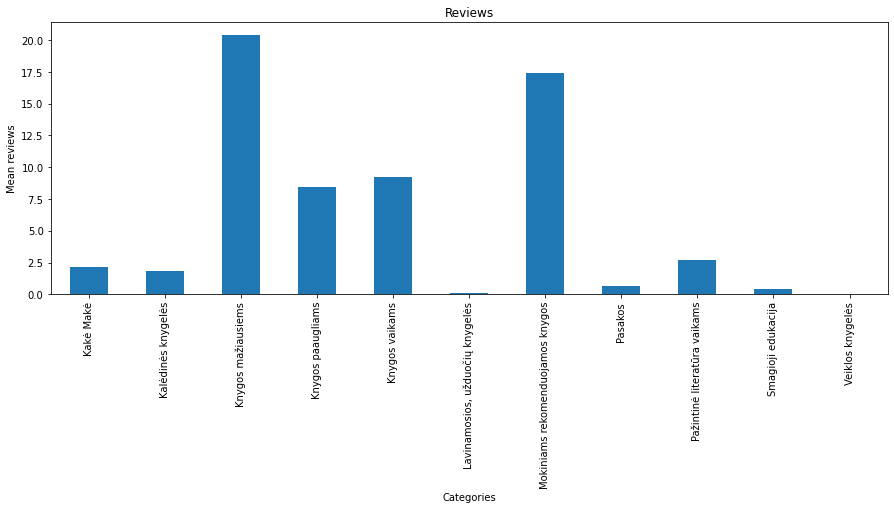

In [ ]:
df_sorted_reviews = df.sort_values(by="reviews", ascending=False)
print(df_sorted_reviews.head())
dfg = df.groupby(['categories'])['reviews'].mean()

dfg.plot(kind='bar', title='Reviews', ylabel='Mean reviews',
         xlabel='Categories', figsize=(15, 5))


We can see that the books that are the most reviewed are the books for young children and the ones recommended for the school. 

# TOP 100
Each book has as well a reference if it is in the top100 books on the website. Let's look what percentage that makes. 



In [ ]:
top_list = []
top = soup.select(".top-number")
for element in top: 
  top_list.append(element.get_text())
print(f"The percentage of youth literature books in the TOP100 is {len(set(top_list))}%.")

The percentage of youth literature books in the TOP100 is 6%.


The highest ranked book is Piktulis (https://www.knygos.lt/lt/knygos/piktulis----siandien-nepyksta--/)



# Nationality of the author

I would like to know what percentage of books are written by Lithuanians. Lithuanian diacritical marks ("ąčęėįšųū") may help me to identify books that are written by Lithuanians.

I noticed that the search indeed seemed to admit mainly Lithuanians although at least two persons whose nationality is not Lithuanian were included in the selection (Pavla Hanáčková, of Czech origin and Ester Dobiášová). However, I keep this approach as it gives me a good approximation. I removed Mrs. Hanáčková and Dobiášová with the .remove() function. 

In [ ]:
lit = "[ąčęėįšųū]"
lit_author = []
for author in df["author"]: 
  if re.search(lit, author): 
    lit_author.append(author)

lit_author.remove("Pavla Hanáčková")
lit_author.remove("Ester Dobiášová, J...")

print(f"The percentage of books in the corpus written by Lituanians is {round((len(lit_author)/len(authors_list))*100,2)} %.")
#TO DO !!!!!


The percentage of books in the corpus written by Lituanians is 15.91 %.


# Information about the price



In [ ]:
# Create list of prices (new and old)
price_new_list = []
price_old_list_all = []
price_old_list = []
price_new = soup.select(".col-12 .new-price")
for element in price_new:
  price_new_list.append(float(element.get_text()[:-2].replace(',','.')))
price_old = soup.select(".col-12 .old-price")
for element in price_old:
  price_old_list_all.append(element.get_text()[:-2])
for element in price_old_list_all: 
  if element[0] != "-": 
    price_old_list.append(float(element.replace(',','.')))

print(f"The average price for a book is {round(sum(price_old_list)/len(price_old_list),2)} euros and {round(sum(price_new_list)/len(price_new_list),2)} euros with discount.")
print(f"The maximum price for a book is {max(price_old_list)} euros.")
print(f"The minimum price for a book is {min(price_old_list)} euros.")


The average price for a book is 13.05 euros and 9.85 euros with discount.
The maximum price for a book is 99.0 euros.
The minimum price for a book is 2.19 euros.


# Conclusion
As noted in this article (https://www.15min.lt/kultura/naujiena/literatura/isaugo-knygu-pardavimas-internetu-daugiausia-vaiku-literaturos-286-1304822), children's literature has done quite well in recent years(especially for younger children), and this has been amplified by the COVID crisis. 

This phenomenon is probably due to the necessity for parents to be involved in the upbringing of their children during the quarantine period.